# Deep Learning - Exercise 8

This lecture is focused on using the attention mechanism in deep learning models.

We recomment reading [this](https://analyticsindiamag.com/a-beginners-guide-to-using-attention-layer-in-neural-networks/) for more detailed information.

[Open in Google colab](https://colab.research.google.com/github/rasvob/VSB-FEI-Deep-Learning-Exercises/blob/main/dl_08.ipynb)
[Download from Github](https://github.com/rasvob/VSB-FEI-Deep-Learning-Exercises/blob/main/dl_08.ipynb)

##### Remember to set **GPU** runtime in Colab!

In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np 
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow import string as tf_string
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.layers import LSTM, GRU, Bidirectional

from sklearn.model_selection import train_test_split # 
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.preprocessing import normalize
from scipy.spatial.distance import cosine
from sklearn.metrics.pairwise import cosine_distances
import scipy
import itertools
import string
import re
import tqdm
import io

import unicodedata, re, string
import nltk
from textblob import TextBlob

tf.version.VERSION

'2.11.0'

In [5]:
tf.config.set_visible_devices([], 'GPU')

In [6]:
def show_history(history):
    plt.figure()
    for key in history.history.keys():
        plt.plot(history.epoch, history.history[key], label=key)
    plt.legend()
    plt.tight_layout()

# 🔎 What is Attention mechanism?

- When we think about the English word “Attention”, we know that it means directing your focus at something and taking greater notice. 
- The Attention mechanism in Deep Learning is based off this concept of directing your focus, and it pays greater attention to certain factors when processing the data.
- Paying attention to important information is necessary and it can improve the performance of the model. 
- **Attention mechanism can help a neural network to memorize long sequences of the information**
    - Remember the RNN and even LSTM long-context issues?

## 🔎 Can you imagine some use-cases where it can help us? 

## There are many variants of the mechanism in the wild but the basic computation process is the same

## The very common and easy to understand example is **Self-Attention Mechanism**
- When an attention mechanism is applied to the network so that it can relate to different positions of a single sequence and can compute the representation of the same sequence, it can be considered as self-attention

![Img01](https://github.com/rasvob/VSB-FEI-Deep-Learning-Exercises/blob/main/images/dl_08_01.png?raw=true)

### The process is usually computed in these few steps

![Img00](https://github.com/rasvob/VSB-FEI-Deep-Learning-Exercises/blob/main/images/dl_08_04.png?raw=true)

- Let’s say that we have an input with n sequences and output y with m sequence in a network.
    - $x=[x_1, x_2, ..., x_n]$
    - $y = [y_1, y_2, ..., y_n]$
    
- The encoder which we are using in the network is a bidirectional LSTM network where it has a forward hidden state and a backward hidden state.
    - Representation of the encoder state can be done by concatenation of these forward and backward states. 
    - $h_i = [h_i^{L2R}, h_i^{R2L}]$

- The hidden state is:
    - $s_t=f(s_{t-1}, y_{t-1}, c_t)$
    
- For the output word at position t, the context vector $C_t$ can be the sum of the hidden states of the input sequence.
- Thus we have:

![Img02](https://github.com/rasvob/VSB-FEI-Deep-Learning-Exercises/blob/main/images/dl_08_02.png?raw=true)

- Here we can see that the sum of the hidden state is weighted by the alignment scores. 
- We can say that ${\alpha_{t,i}}$  are the weights that are responsible for defining how much of each source’s hidden state should be taken into consideration for each output.

- There can be various types of alignment scores according to their geometry. 
    - It can be either linear or in the curve geometry. 

- Below are some of the popular attention mechanisms:

![Img03](https://github.com/rasvob/VSB-FEI-Deep-Learning-Exercises/blob/main/images/dl_08_03.png?raw=true)

## Punkt Sentence Tokenizer

* This tokenizer divides a text into a list of sentences by using an unsupervised algorithm to build a model for abbreviation words, collocations, and words that start sentences. It must be trained on a large collection of plaintext in the target language before it can be used.

In [6]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /home/fei/svo0175/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Download the dataset

In [7]:
df = pd.read_csv('https://github.com/rasvob/VSB-FEI-Deep-Learning-Exercises/raw/main/datasets/train_tweets.csv')

# Let's take a look at the data

In [8]:
df.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [9]:
df.shape

(31962, 3)

## We can see that the classification task is highly imbalanced, because we have only 2242 negative tweets compared with positive one

<Axes: xlabel='label', ylabel='count'>

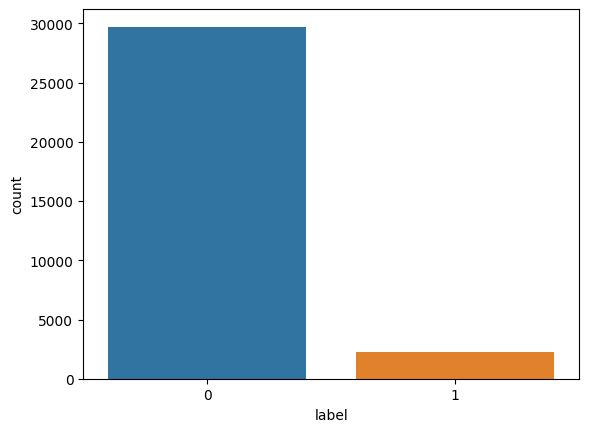

In [10]:
sns.countplot(x='label', data=df)

In [11]:
df.label.value_counts()

0    29720
1     2242
Name: label, dtype: int64

In [12]:
df['length'] = df.tweet.apply(len)

### We can see that the sentences are of similar lengths

<Axes: xlabel='label', ylabel='length'>

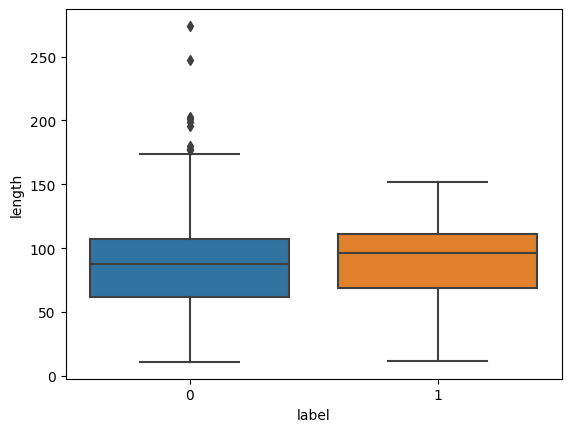

In [13]:
sns.boxplot(x='label', y='length', data = df)

## We can see that the text data are full of noise

* 💡 Social posts suffer the most from this effect
    * The text is full of hashtags, emojis, @mentions and so on
* These parts usually don't influence the sentiment score by much
* Although most advanced models usually extract even this features because e.g. emojis can help you with the sarcasm understanding

## Take a look at few examples, it will share many of these caveates which we discussed for sure

In [14]:
for x in df.loc[:10, 'tweet']:
    print(x)
    print('---------')

 @user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction.   #run
---------
@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx.    #disapointed #getthanked
---------
  bihday your majesty
---------
#model   i love u take with u all the time in urð±!!! ððððð¦ð¦ð¦  
---------
 factsguide: society now    #motivation
---------
[2/2] huge fan fare and big talking before they leave. chaos and pay disputes when they get there. #allshowandnogo  
---------
 @user camping tomorrow @user @user @user @user @user @user @user dannyâ¦
---------
the next school year is the year for exams.ð¯ can't think about that ð­ #school #exams   #hate #imagine #actorslife #revolutionschool #girl
---------
we won!!! love the land!!! #allin #cavs #champions #cleveland #clevelandcavaliers  â¦ 
---------
 @user @user welcome here !  i'm   it's so #gr8 ! 
---------
 â #ireland consumer price index (mom) climbed f

# 💡Text data pre-processing uses a few specific techniques
* Benefit of using these techniques varies from approach to approach
* However it is good to have some knowledge about them

## Stemming
* Stemming is the process of producing morphological variants of a root/base word. 
    * Stemming programs are commonly referred to as stemming algorithms or stemmers. 
* A stemming algorithm reduces the words “chocolates”, “chocolatey”, “choco” to the root word, “chocolate” and “retrieval”, “retrieved”, “retrieves” reduce to the stem “retrieve”

#### 💡 Examples of stemming:
* chocolates, chocolatey, choco : chocolate
* retrieval, retrieved, retrieves : retrieve


## Lemmatization 
* Lemmatization is the process of grouping together the different inflected forms of a word so they can be analysed as a single item. Lemmatization is similar to stemming but it brings context to the words. So it links words with similar meaning to one word.

#### 💡 Examples of lemmatization:
* rocks : rock
* corpora : corpus
* better : good

## Both techiques can be used in the preprocessing pipeline
* You have to decide if it is beneficial to you, because this steps leads to some generalization of the data by itself. 
    * You will definitely lose some pieces of the information. 

# 💡Embedding tip
* If you use some form of embedding like Word2Vec or Glove, it is better to skip this steps because the embedding vocabulary skipped it as well. 🙂

## You don't have to code the pre-process steps yourself
* We have already prepared the most common functions used
* Modify function *normalize()* for different steps

In [15]:
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def remove_numbers(words):
    """Remove all interger occurrences in list of tokenized words with textual representation"""
    new_words = []
    for word in words:
        new_word = re.sub("\d+", "", word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopwords.words('english'):
            new_words.append(word)
    return new_words

def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = LancasterStemmer()
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

def normalize(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
# words = remove_punctuation(words)
    words = remove_numbers(words)
#    words = remove_stopwords(words)
    return words

def form_sentence(tweet):
    tweet_blob = TextBlob(tweet)
    return tweet_blob.words

# Tokenize sentences and remove puncuation by TextBlob library

In [16]:
df['Words'] = df['tweet'].apply(form_sentence)

In [17]:
df.head()

,id,label,tweet,length,Words
0,1,0,@user when a father is dysfunctional and is s...,102,"[user, when, a, father, is, dysfunctional, and..."
1,2,0,@user @user thanks for #lyft credit i can't us...,122,"[user, user, thanks, for, lyft, credit, i, ca,..."
2,3,0,bihday your majesty,21,"[bihday, your, majesty]"
3,4,0,#model i love u take with u all the time in ...,86,"[model, i, love, u, take, with, u, all, the, t..."
4,5,0,factsguide: society now #motivation,39,"[factsguide, society, now, motivation]"


# Normalize sentences 
* We want only ascii and lowercase text and no numbers in the strings

## You can experiments with different preprocess steps as you wish! 🙂

In [18]:
df['Words_normalized'] = df['Words'].apply(normalize)

In [19]:
df.head()

,id,label,tweet,length,Words,Words_normalized
0,1,0,@user when a father is dysfunctional and is s...,102,"[user, when, a, father, is, dysfunctional, and...","[user, when, a, father, is, dysfunctional, and..."
1,2,0,@user @user thanks for #lyft credit i can't us...,122,"[user, user, thanks, for, lyft, credit, i, ca,...","[user, user, thanks, for, lyft, credit, i, ca,..."
2,3,0,bihday your majesty,21,"[bihday, your, majesty]","[bihday, your, majesty]"
3,4,0,#model i love u take with u all the time in ...,86,"[model, i, love, u, take, with, u, all, the, t...","[model, i, love, u, take, with, u, all, the, t..."
4,5,0,factsguide: society now #motivation,39,"[factsguide, society, now, motivation]","[factsguide, society, now, motivation]"


## Remove the 'user' word from tweets

In [20]:
df['Words_normalized_no_user'] = df['Words_normalized'].apply(lambda x: [y for y in x if 'user' not in y])

In [21]:
df.head()

,id,label,tweet,length,Words,Words_normalized,Words_normalized_no_user
0,1,0,@user when a father is dysfunctional and is s...,102,"[user, when, a, father, is, dysfunctional, and...","[user, when, a, father, is, dysfunctional, and...","[when, a, father, is, dysfunctional, and, is, ..."
1,2,0,@user @user thanks for #lyft credit i can't us...,122,"[user, user, thanks, for, lyft, credit, i, ca,...","[user, user, thanks, for, lyft, credit, i, ca,...","[thanks, for, lyft, credit, i, ca, n't, use, c..."
2,3,0,bihday your majesty,21,"[bihday, your, majesty]","[bihday, your, majesty]","[bihday, your, majesty]"
3,4,0,#model i love u take with u all the time in ...,86,"[model, i, love, u, take, with, u, all, the, t...","[model, i, love, u, take, with, u, all, the, t...","[model, i, love, u, take, with, u, all, the, t..."
4,5,0,factsguide: society now #motivation,39,"[factsguide, society, now, motivation]","[factsguide, society, now, motivation]","[factsguide, society, now, motivation]"


## We can see that no pre-processing is ideal and we have to fix some issues by ourselves
* e.g. n't splitting

In [22]:
print(df.tweet.iloc[1])
print(df.Words_normalized_no_user.iloc[1])

@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx.    #disapointed #getthanked
['thanks', 'for', 'lyft', 'credit', 'i', 'ca', "n't", 'use', 'cause', 'they', 'do', "n't", 'offer', 'wheelchair', 'vans', 'in', 'pdx', 'disapointed', 'getthanked']


In [23]:
def fix_nt(words):
    st_res = []
    for i in range(0, len(words) - 1):
        if words[i+1] == "n't" or words[i+1] == "nt":
            st_res.append(words[i]+("n't"))
        else:
            if words[i] != "n't" and words[i] != "nt":
                st_res.append(words[i])
    return st_res

In [24]:
df['Words_normalized_no_user_fixed'] = df['Words_normalized_no_user'].apply(fix_nt)

## The issue is now fixed

In [25]:
print(df.tweet.iloc[1])
print(df.Words_normalized_no_user.iloc[1])
print(df.Words_normalized_no_user_fixed.iloc[1])

@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx.    #disapointed #getthanked
['thanks', 'for', 'lyft', 'credit', 'i', 'ca', "n't", 'use', 'cause', 'they', 'do', "n't", 'offer', 'wheelchair', 'vans', 'in', 'pdx', 'disapointed', 'getthanked']
['thanks', 'for', 'lyft', 'credit', 'i', "can't", 'use', 'cause', 'they', "don't", 'offer', 'wheelchair', 'vans', 'in', 'pdx', 'disapointed']


## We can join the text into single string for each instance

In [26]:
df['Clean_text'] = df['Words_normalized_no_user_fixed'].apply(lambda x: " ".join(x))

In [27]:
df['Clean_text'].head()

0    when a father is dysfunctional and is so selfi...
1    thanks for lyft credit i can't use cause they ...
2                                          bihday your
3           model i love u take with u all the time in
4                               factsguide society now
Name: Clean_text, dtype: object

# Let's take a look at the most common words in corpus
* It is one of the usual EDA step for text data
* Although without any preprocessing there will be a lot of so-called *stopwords*

## 🔎 Do you know what the term **stopword** mean?

## Just tokenize every string and merge the token array into one big array using *itertools.chain()*

In [28]:
all_words = list(itertools.chain(*df.Words_normalized_no_user_fixed))

In [29]:
all_words[:10]

['when',
 'a',
 'father',
 'is',
 'dysfunctional',
 'and',
 'is',
 'so',
 'selfish',
 'he']

## Compute frequency of every token using *nltk*

In [30]:
dist = nltk.FreqDist(all_words)

## The most common tokens are:

In [31]:
dist

FreqDist({'the': 10136, 'to': 9798, 'a': 7680, 'i': 7165, 'you': 5679, 'and': 4868, 'in': 4615, 'for': 4462, 'of': 4133, 'is': 4048, ...})

## We have 34289 unique words (tokens)

In [32]:
len(dist)

34292

## The longest tweet has 42 words

In [33]:
max(df.Words_normalized_no_user_fixed.apply(len))

42

# Our dataset is ready, we can start our Deep learning experiments 🚀

## Can you use regular FCANN for the sentiment analysis?

![Meme01](https://github.com/rasvob/VSB-FEI-Deep-Learning-Exercises/blob/main/images/dl_06_meme_01.png?raw=true)


# We will use TextVectorization layer for creating vector model from our text data
* For those of you who are interested in the topic there is very good [article on Medium](https://towardsdatascience.com/you-should-try-the-new-tensorflows-textvectorization-layer-a80b3c6b00ee) about the layer and its parameters.

* There is of course a [documentation page](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization) about the layer as well.

## What does Text vectorization mean in this context?
* Is it any different term from the one used in information retrieval?

## There is a few important parameters:
* emedding_dim 
    * Dimension of embedded representation
    * This is already part of latent space, there is captured dependecy among words in these vectors, we are learning this vectors using the ANN
* vocab_size
    * Number of unique tokens in vocabulary
* sequence_length
    * Output dimension after vectorizing - words in vectorited representation are independent

In [34]:
embedding_dim = 128 # Dimension of embedded representation - this is already part of latent space, there is captured some dependecy among words, we are learning this vectors in ANN
vocab_size = 10000 # Number of unique tokens in vocabulary
sequence_length = 30 # Output dimension after vectorizing - words in vectorited representation are independent

vect_layer = TextVectorization(max_tokens=vocab_size, output_mode='int', output_sequence_length=sequence_length)
vect_layer.adapt(df.Clean_text.values)

2023-04-18 12:34:22.983635: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## We will split our dataset to train and test parts with stratification

## ⚠⚠ COMPETITION TEST SET HERE ⚠⚠

### COMPETITION ?!?! 🤔
* I will provide the details in the end of the lecture 🙂

In [35]:
X_train, X_test, y_train, y_test = train_test_split(df.Clean_text, df.label, test_size=0.20, random_state=13, stratify=df.label)

In [36]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=13, stratify=y_train)

In [37]:
print(X_train.shape, X_test.shape)

(23012,) (6393,)


In [38]:
print('Train')
print(y_train.value_counts())
print('Test')
print(y_test.value_counts())

Train
0    21397
1     1615
Name: label, dtype: int64
Test
0    5945
1     448
Name: label, dtype: int64


In [39]:
print('Vocabulary example: ', vect_layer.get_vocabulary()[:10])
print('Vocabulary shape: ', len(vect_layer.get_vocabulary()))

Vocabulary example:  ['', '[UNK]', 'the', 'to', 'a', 'i', 'you', 'and', 'in', 'for']
Vocabulary shape:  10000


In [40]:
input_layer = keras.layers.Input(shape=(1,), dtype=tf_string)
x_v = vect_layer(input_layer)
emb = keras.layers.Embedding(vocab_size, embedding_dim)(x_v)
x = LSTM(64, activation='relu', return_sequences=True)(emb)
x = GRU(64, activation='relu', return_sequences=True)(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(64, 'relu')(x)
x = keras.layers.Dense(32, 'relu')(x)
x = keras.layers.Dropout(0.2)(x)
output_layer = keras.layers.Dense(1, 'sigmoid')(x)

model = keras.Model(input_layer, output_layer)
model.summary()

model.compile(optimizer=keras.optimizers.RMSprop(), loss=keras.losses.BinaryCrossentropy(), metrics=keras.metrics.BinaryAccuracy())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 30)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 30, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 30, 64)            49408     
                                                                 
 gru (GRU)                   (None, 30, 64)            24960     
                                                                 
 flatten (Flatten)           (None, 1920)              0         
                                                             

In [41]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='weights.best.tf',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

Epoch 1/5
  1/180 [..............................] - ETA: 7:58 - loss: 0.6941 - binary_accuracy: 0.2734

2023-04-18 12:34:28.158065: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7fe5b005f100 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-04-18 12:34:28.158124: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Host, Default Version
2023-04-18 12:34:28.168570: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-04-18 12:34:28.199318: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


180/180 [==============================] - 26s 129ms/step - loss: 0.2500 - binary_accuracy: 0.9261 - val_loss: 0.1708 - val_binary_accuracy: 0.9300
Epoch 2/5
180/180 [==============================] - 16s 89ms/step - loss: 0.1535 - binary_accuracy: 0.9487 - val_loss: 0.1280 - val_binary_accuracy: 0.9585
Epoch 3/5
180/180 [==============================] - 15s 82ms/step - loss: 0.1115 - binary_accuracy: 0.9653 - val_loss: 0.1277 - val_binary_accuracy: 0.9585
Epoch 4/5
180/180 [==============================] - 14s 77ms/step - loss: 0.0907 - binary_accuracy: 0.9723 - val_loss: 0.1173 - val_binary_accuracy: 0.9621
Epoch 5/5
180/180 [==============================] - 14s 77ms/step - loss: 0.0732 - binary_accuracy: 0.9784 - val_loss: 0.1367 - val_binary_accuracy: 0.9496


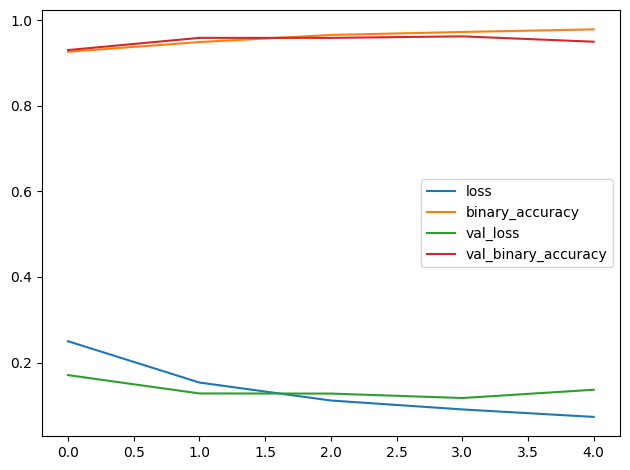

In [42]:
batch_size = 128
epochs = 5

history = model.fit(X_train.values, y_train.values, validation_data=(X_valid.values, y_valid.values), callbacks=[model_checkpoint_callback], epochs=epochs, batch_size=batch_size)

show_history(history)

In [43]:
# Load best setup
model.load_weights("weights.best.tf")

In [44]:
y_pred = model.predict(X_test).ravel()

200/200 [==============================] - 3s 14ms/step


## Sigmoid function gives us real number in range <0, 1>.

In [45]:
y_pred[:10]

array([0.00527707, 0.00390909, 0.00112395, 0.04396923, 0.0001038 ,
       0.00014713, 0.07438087, 0.00204616, 0.06307434, 0.00381176],
      dtype=float32)

## We need to map this values to discreet classes 0 and 1

In [46]:
y_pred = [1 if x >= 0.5 else 0 for x in y_pred]

In [47]:
y_pred[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

# We can see that accuracy is not the best metric in the imbalanced situation - you already know the reason 🙂
* There are many more metrics we can use and one of the most common in this situation is the F1 Score, see [this](https://en.wikipedia.org/wiki/F-score) and [this](https://machinelearningmastery.com/classification-accuracy-is-not-enough-more-performance-measures-you-can-use/) for more info

In [48]:
accuracy_score(y_true=y_test, y_pred=y_pred)

0.9602690442671672

In [49]:
f1_score(y_true=y_test, y_pred=y_pred)

0.6586021505376345

In [50]:
print(classification_report(y_true=y_test, y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      5945
           1       0.83      0.55      0.66       448

    accuracy                           0.96      6393
   macro avg       0.90      0.77      0.82      6393
weighted avg       0.96      0.96      0.96      6393



In [58]:
import keras.backend as K
class attention(tf.keras.layers.Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)

    def build(self,input_shape):
        self.W=self.add_weight(name="att_weight",shape=(input_shape[-1],1),initializer="normal")
        self.b=self.add_weight(name="att_bias",shape=(input_shape[1],1),initializer="zeros")        
        super(attention, self).build(input_shape)

    def call(self,x):
        et=K.squeeze(K.tanh(K.dot(x,self.W)+self.b),axis=-1)
        at=K.softmax(et)
        at=K.expand_dims(at,axis=-1)
        output=x*at
        return K.sum(output,axis=1)

    def compute_output_shape(self,input_shape):
        return (input_shape[0],input_shape[-1])

    def get_config(self):
        return super(attention,self).get_config()

In [71]:
input_layer = keras.layers.Input(shape=(1,), dtype=tf_string)
x_v = vect_layer(input_layer)
emb = keras.layers.Embedding(vocab_size, embedding_dim)(x_v)
x = LSTM(64, activation='relu', return_sequences=True)(emb)
x = GRU(64, activation='relu', return_sequences=True)(x)
x = attention(name='attention_layer')(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(64, 'relu')(x)
x = keras.layers.Dense(32, 'relu')(x)
x = keras.layers.Dropout(0.2)(x)
output_layer = keras.layers.Dense(1, 'sigmoid')(x)

model = keras.Model(input_layer, output_layer)
model.summary()

model.compile(optimizer=keras.optimizers.RMSprop(), loss=keras.losses.BinaryCrossentropy(), metrics=keras.metrics.BinaryAccuracy())

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 30)               0         
 torization)                                                     
                                                                 
 embedding_4 (Embedding)     (None, 30, 128)           1280000   
                                                                 
 lstm_4 (LSTM)               (None, 30, 64)            49408     
                                                                 
 gru_4 (GRU)                 (None, 30, 64)            24960     
                                                                 
 attention_layer (attention)  (None, 64)               94        
                                                           

In [60]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='weights.best.tf',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

In [90]:
batch_size = 128
epochs = 5

history = model.fit(X_train.values, y_train.values, validation_data=(X_valid.values, y_valid.values), callbacks=[model_checkpoint_callback], epochs=epochs, batch_size=batch_size)

show_history(history)

[[1.07240481e-02 2.36262679e-01 2.96727300e-01 5.27699888e-01
  6.57943010e-01 1.69689022e-02 0.00000000e+00 6.81801438e-01
  6.95027848e-05 5.13374567e-01 7.69513845e-02 9.10306349e-03
  3.11261326e-01 6.44176602e-01 2.28095874e-02 6.15983069e-01
  2.83574162e-04 4.76580232e-01 2.14499272e-02 2.84529001e-01
  2.51116287e-02 1.53434351e-01 3.50658029e-01 2.75402442e-02
  0.00000000e+00 5.33932030e-01 0.00000000e+00 0.00000000e+00
  0.00000000e+00 9.06500667e-02 5.27918756e-01 3.17751803e-02
  1.02418082e-04 1.60193130e-01 6.49790645e-01 7.05329657e-01
  7.06768930e-01 0.00000000e+00 5.43794096e-01 0.00000000e+00
  1.13014793e-02 5.94590306e-01 0.00000000e+00 5.59661746e-01
  1.35800689e-02 4.43618834e-01 5.71213663e-01 0.00000000e+00
  4.15271103e-01 1.95453644e-01 4.20098426e-03 5.57993472e-01
  6.61744595e-01 1.24814510e+00 3.55934165e-02 2.06983224e-01
  0.00000000e+00 3.43805134e-01 5.12118697e-01 7.11067557e-01
  6.60127401e-03 6.88060001e-03 6.95300043e-01 3.04422528e-01]
 [2.126

KeyError: 'key of type tuple not found and not a MultiIndex'

In [ ]:
# Load best setup
model.load_weights("weights.best.tf")

In [63]:
y_pred = model.predict(X_test).ravel()

200/200 [==============================] - 3s 14ms/step


## Sigmoid function gives us real number in range <0, 1>.

In [64]:
y_pred[:10]

array([5.3203600e-03, 1.3573790e-02, 1.1487746e-03, 3.9944522e-02,
       7.1169576e-05, 7.7596982e-05, 6.5831766e-02, 5.9847338e-03,
       7.0061207e-02, 2.3810463e-02], dtype=float32)

## We need to map this values to discreet classes 0 and 1

In [65]:
y_pred = [1 if x >= 0.5 else 0 for x in y_pred]

In [66]:
y_pred[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

# We can see that accuracy is not the best metric in the imbalanced situation - you already know the reason 🙂
* There are many more metrics we can use and one of the most common in this situation is the F1 Score, see [this](https://en.wikipedia.org/wiki/F-score) and [this](https://machinelearningmastery.com/classification-accuracy-is-not-enough-more-performance-measures-you-can-use/) for more info

In [67]:
accuracy_score(y_true=y_test, y_pred=y_pred)

0.9571406225559206

In [68]:
f1_score(y_true=y_test, y_pred=y_pred)

0.6625615763546798

In [69]:
print(classification_report(y_true=y_test, y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98      5945
           1       0.74      0.60      0.66       448

    accuracy                           0.96      6393
   macro avg       0.85      0.79      0.82      6393
weighted avg       0.95      0.96      0.96      6393



In [6]:
from keract import get_activations
plt.rcParams.update({'font.size': 8})

class VisualizeAttentionMap(tf.keras.callbacks.Callback):

    def __init__(self, model, x):
        super().__init__()
        self.model = model
        self.x = x

    def on_epoch_begin(self, epoch, logs=None):
        attention_map = get_activations(self.model, self.x, layer_names='attention_weight')['attention_weight']
        x = self.x[..., 0]
        plt.close()
        fig, axes = plt.subplots(nrows=3, figsize=(10, 8))
        maps = [attention_map, create_argmax_mask(attention_map), create_argmax_mask(x)]
        print(attention_map.shape)
        maps_names = ['attention layer (continuous)', 'attention layer - argmax (discrete)', 'ground truth (discrete)']
        for i, ax in enumerate(axes.flat):
            im = ax.imshow(maps[i], interpolation='none', cmap='jet')
            ax.set_ylabel(maps_names[i] + '\n#sample axis')
            ax.set_xlabel('sequence axis')
            ax.xaxis.set_ticks([])
            ax.yaxis.set_ticks([])
        cbar_ax = fig.add_axes([0.75, 0.15, 0.05, 0.7])
        fig.colorbar(im, cax=cbar_ax)
        fig.suptitle(f'Epoch {epoch} - training\nEach plot shows a 2-D matrix x-axis: sequence length * y-axis: '
                     f'batch/sample axis. \nThe first matrix contains the attention weights (softmax).'
                     f'\nWe manually apply argmax on the attention weights to see which time step ID has '
                     f'the strongest weight. \nFinally, the last matrix displays the ground truth. The task '
                     f'is solved when the second and third matrix match.')
        plt.draw()
        plt.pause(0.001)


def create_argmax_mask(x):
    mask = np.zeros_like(x)
    for i, m in enumerate(x.argmax(axis=1)):
        mask[i, m] = 1
    return mask

(12, 10)


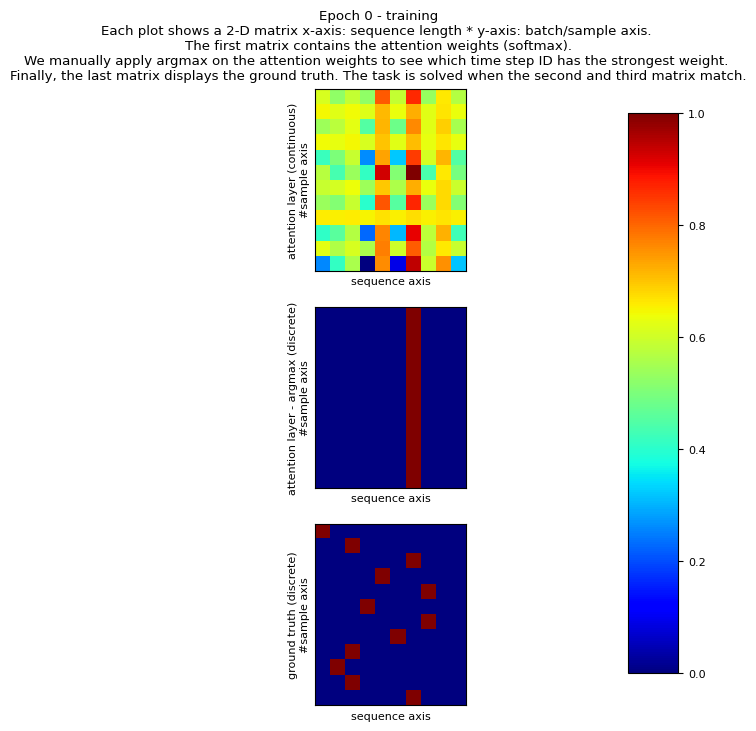

Epoch 1/100


2023-04-18 14:21:45.823288: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "111" frequency: 2200 num_cores: 40 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 262144 l3_cache_size: 26214400 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


157/157 [==============================] - ETA: 0s - loss: 0.1372

2023-04-18 14:21:54.161354: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "111" frequency: 2200 num_cores: 40 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 262144 l3_cache_size: 26214400 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


157/157 [==============================] - 11s 56ms/step - loss: 0.1372 - val_loss: 0.1246
(12, 10)


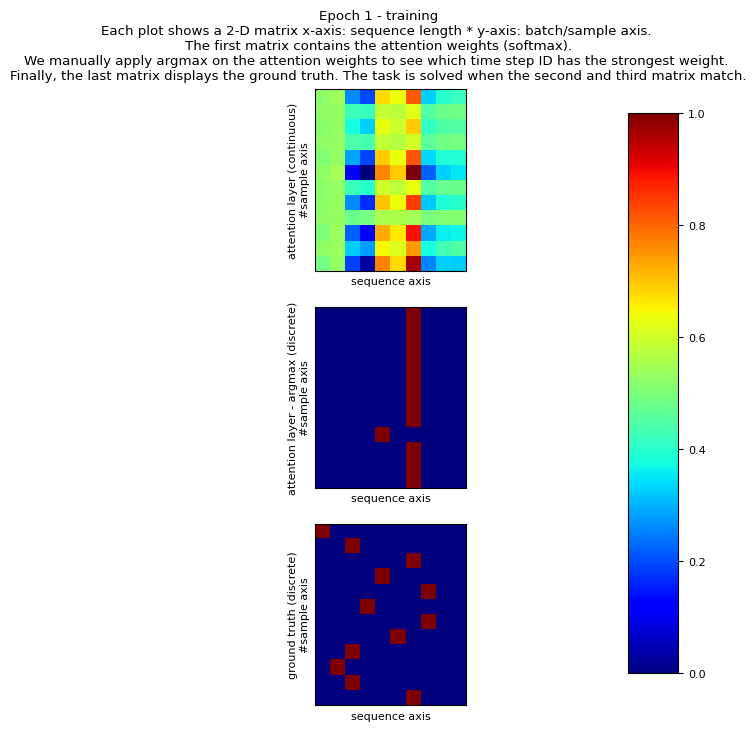

Epoch 2/100
157/157 [==============================] - 8s 52ms/step - loss: 0.1189 - val_loss: 0.1053
(12, 10)


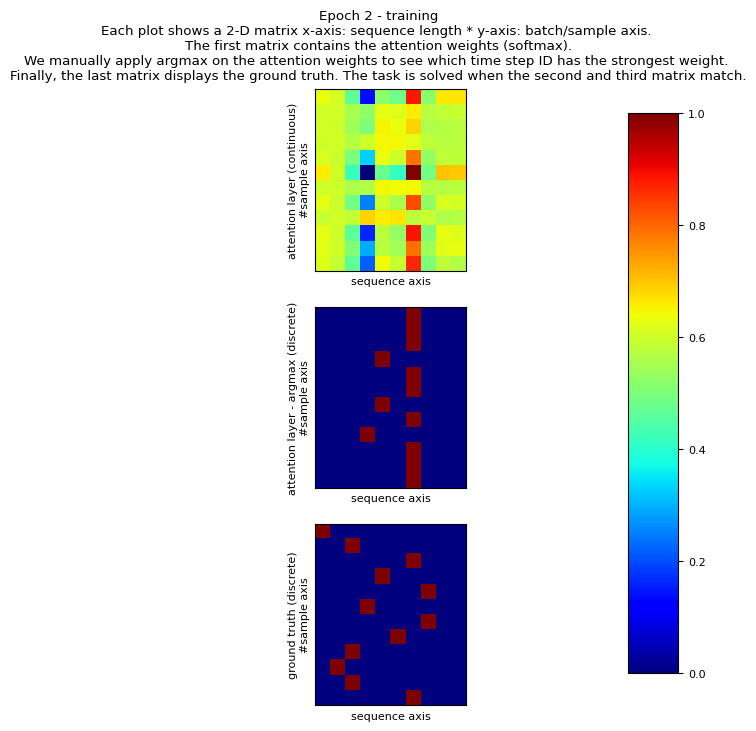

Epoch 3/100
157/157 [==============================] - 8s 50ms/step - loss: 0.1044 - val_loss: 0.0966
(12, 10)


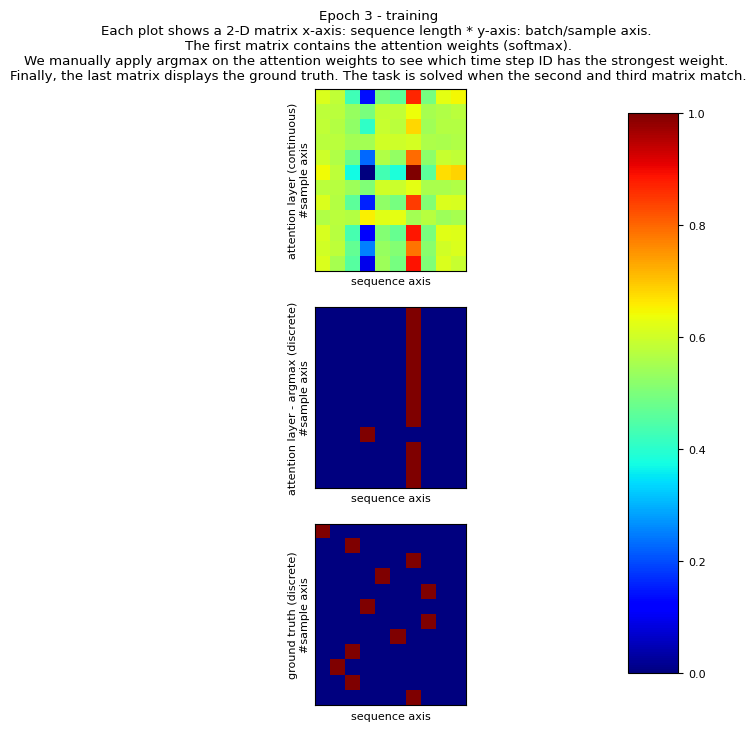

Epoch 4/100
157/157 [==============================] - 8s 50ms/step - loss: 0.0973 - val_loss: 0.0954
(12, 10)


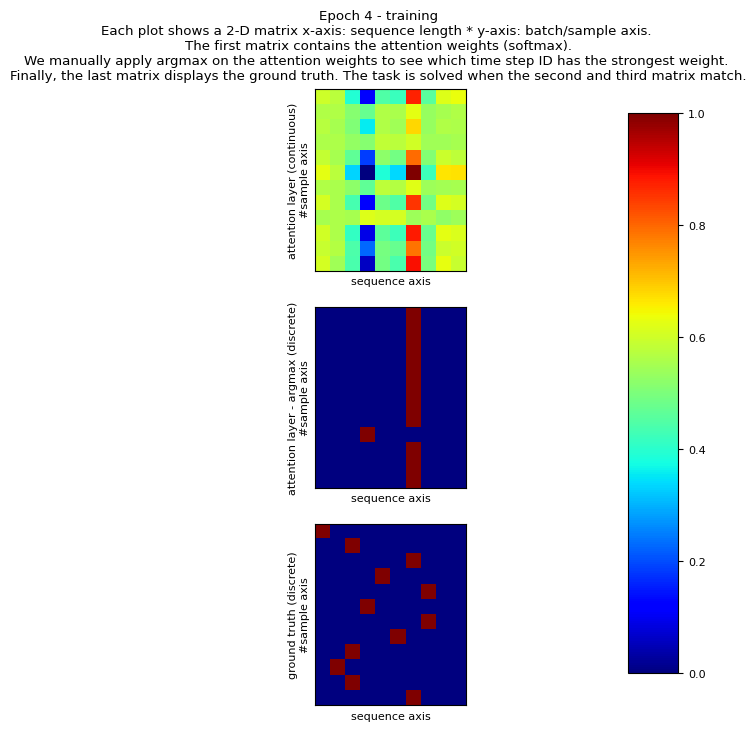

Epoch 5/100
157/157 [==============================] - 8s 51ms/step - loss: 0.0907 - val_loss: 0.0887
(12, 10)


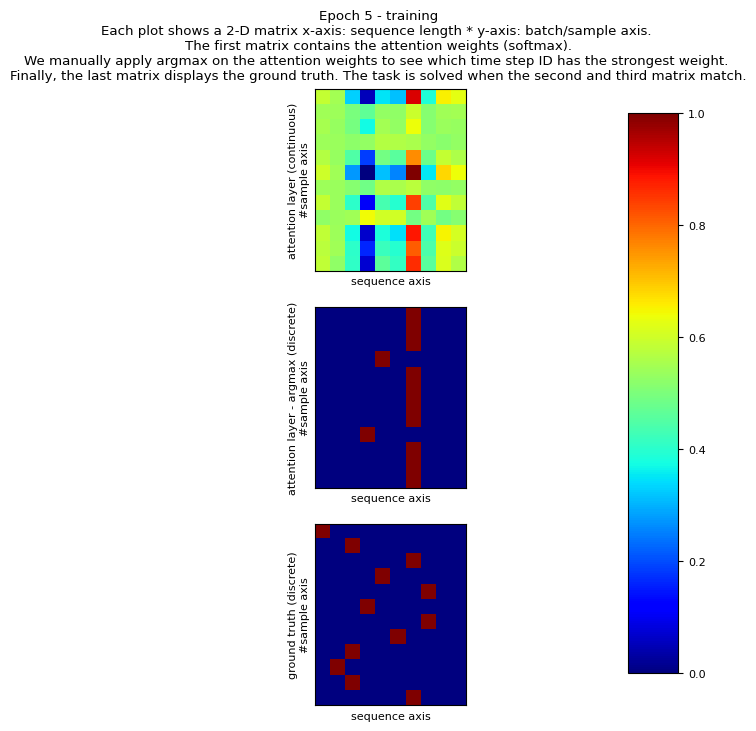

Epoch 6/100
157/157 [==============================] - 8s 51ms/step - loss: 0.0851 - val_loss: 0.0790
(12, 10)


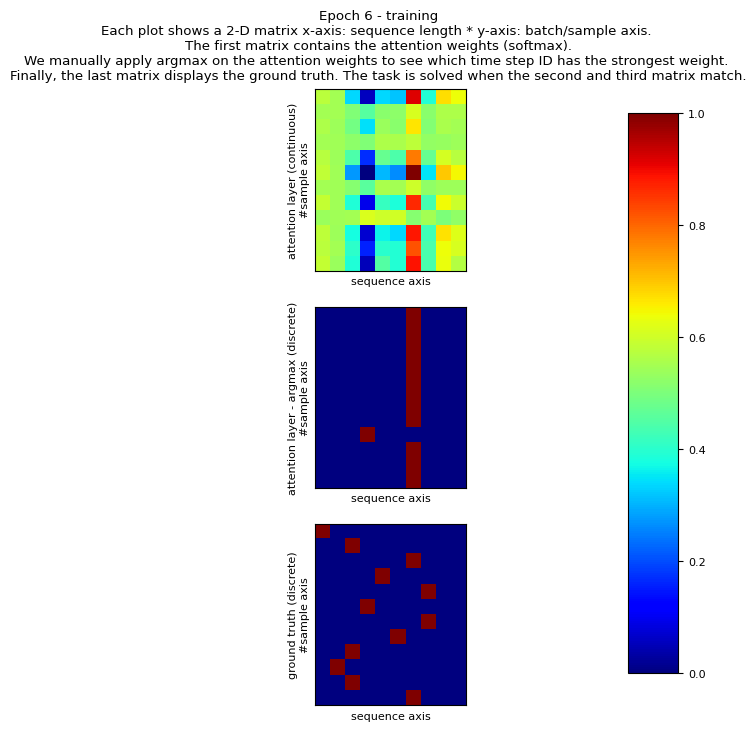

Epoch 7/100
157/157 [==============================] - 8s 51ms/step - loss: 0.0773 - val_loss: 0.0830
(12, 10)


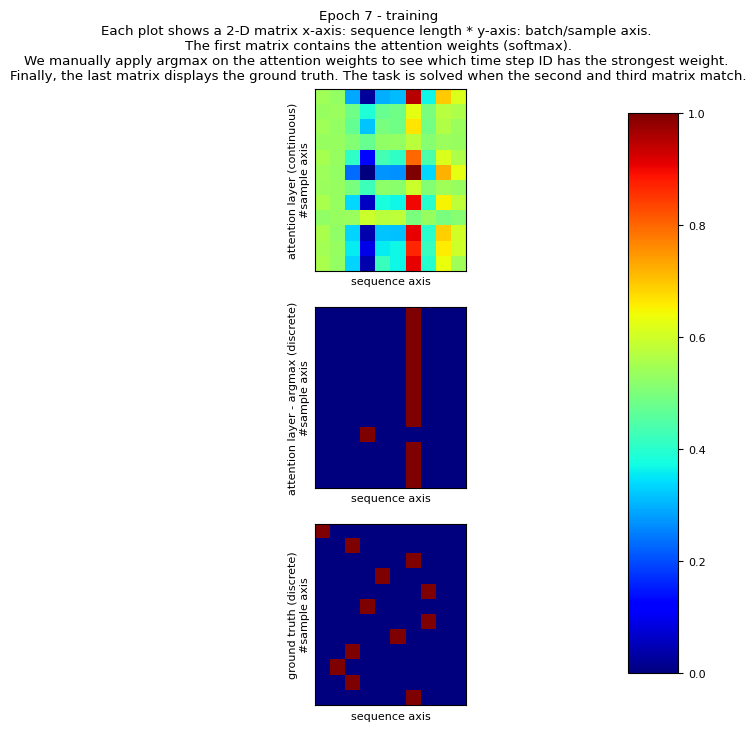

Epoch 8/100
157/157 [==============================] - 8s 52ms/step - loss: 0.0618 - val_loss: 0.0551
(12, 10)


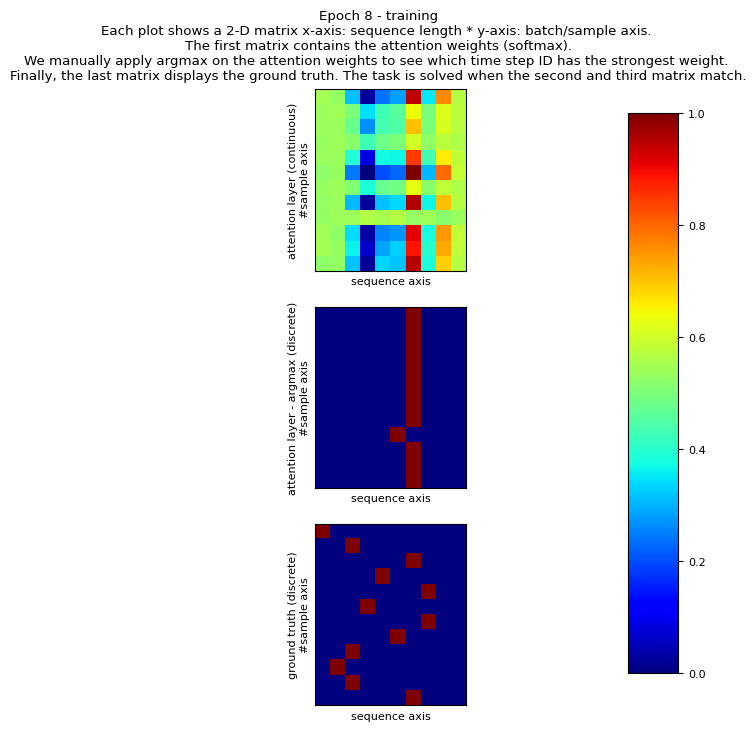

Epoch 9/100
157/157 [==============================] - 8s 51ms/step - loss: 0.0472 - val_loss: 0.0452
(12, 10)


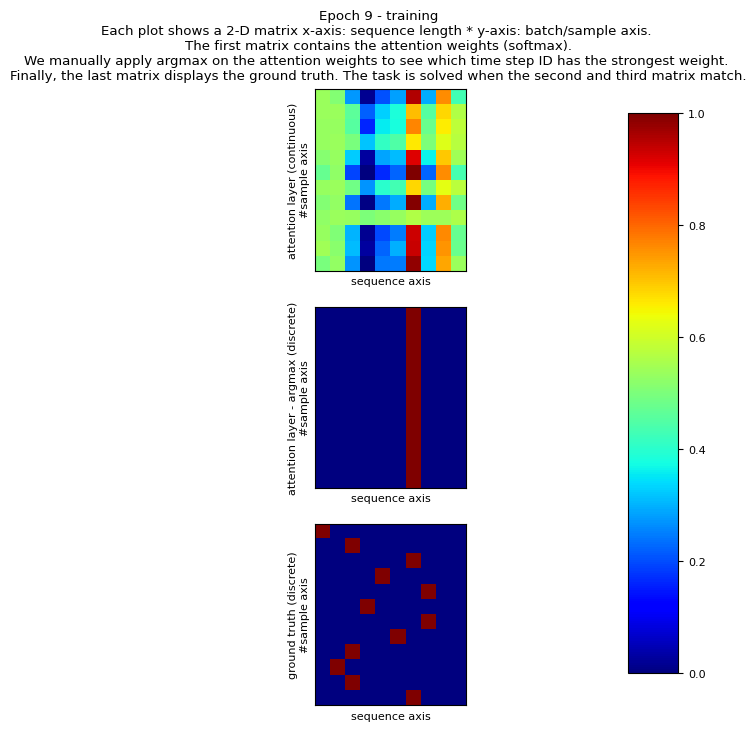

Epoch 10/100
157/157 [==============================] - 8s 51ms/step - loss: 0.0398 - val_loss: 0.0395
(12, 10)


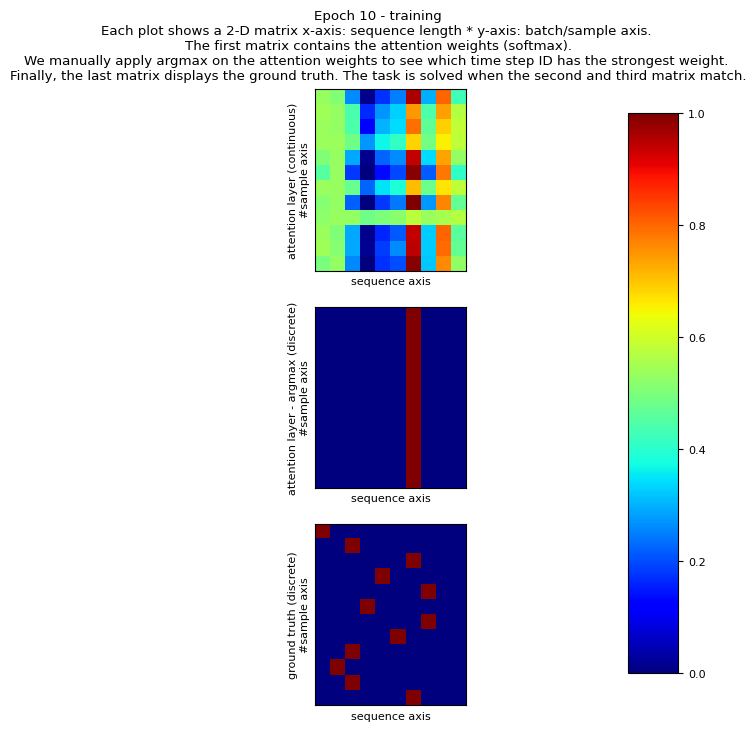

Epoch 11/100
157/157 [==============================] - 8s 51ms/step - loss: 0.0359 - val_loss: 0.0359
(12, 10)


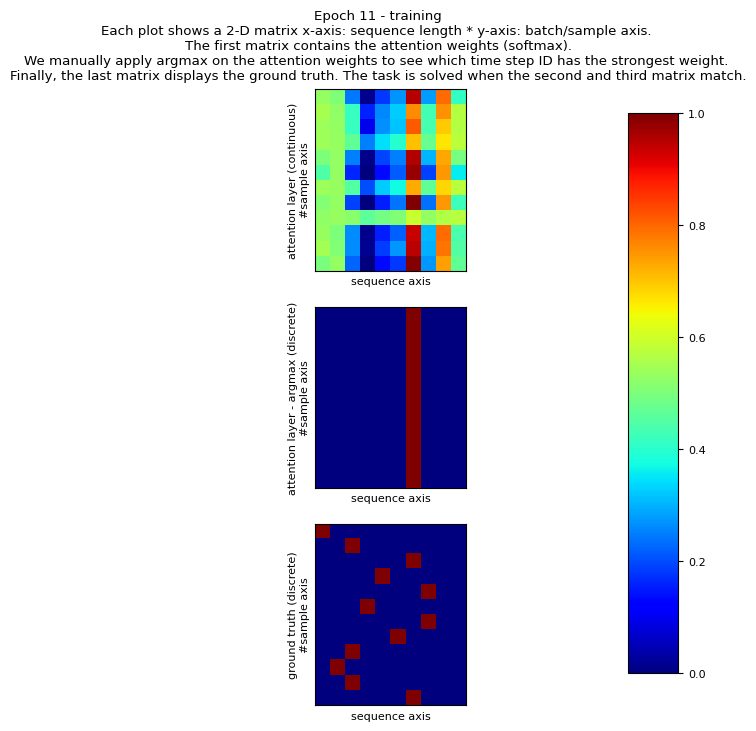

Epoch 12/100
 91/157 [================>.............] - ETA: 2s - loss: 0.0332

KeyboardInterrupt: 

In [9]:
from attention import Attention
import os
os.environ['KERAS_ATTENTION_DEBUG'] = '1'
seq_length = 10
num_samples = 100000
# https://stats.stackexchange.com/questions/485784/which-distribution-has-its-maximum-uniformly-distributed
# Choose beta(1/N,1) to have max(X_1,...,X_n) ~ U(0, 1) => minimizes amount of knowledge.
# If all the max(s) are concentrated around 1, then it makes the task easy for the model.
x_data = np.random.beta(a=1 / seq_length, b=1, size=(num_samples, seq_length, 1))
y_data = np.max(x_data, axis=1)

# NOTE: can't use Sequential in debug with KERAS_ATTENTION_DEBUG=1.
# Because the layer Attention is no longer considered as a Keras layer.
# That's the trick to "see" the internal outputs of each tensor in the attention module.
# In practice, you can use Sequential without debug enabled ;)
# model = Sequential([
#     LSTM(128, input_shape=(seq_length, 1), return_sequences=True),
#     Attention(),
#     Dense(1, activation='linear')
# ])
model_input = keras.layers.Input(shape=(seq_length, 1))
x = keras.layers.LSTM(128, return_sequences=True)(model_input)
x = Attention(units=seq_length, name='attention_weight')(x)
x = keras.layers.Dense(1, activation='linear')(x)
model = keras.Model(model_input, x)

model.compile(loss='mae')
max_epoch = 100
# visualize the attention on the first samples.
visualize = VisualizeAttentionMap(model, x_data[0:12])
model.fit(x_data, y_data, epochs=max_epoch, validation_split=0.2, callbacks=[visualize], batch_size=512)

In [18]:
import os
import shutil
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy
import numpy as np
from keract import get_activations
from tensorflow.keras import Input
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.models import Model
from tensorflow.python.keras.utils.vis_utils import plot_model

# KERAS_ATTENTION_DEBUG: If set to 1. Will switch to debug mode.
# In debug mode, the class Attention is no longer a Keras layer.
# What it means in practice is that we can have access to the internal values
# of each tensor. If we don't use debug, Keras treats the object
# as a layer, and we can only get the final output.

# In this example we need it because we want to extract all the intermediate output values.
os.environ['KERAS_ATTENTION_DEBUG'] = '1'
from attention import Attention


def task_add_two_numbers_after_delimiter(
        n: int, seq_length: int, delimiter: float = 0.0,
        index_1: int = None, index_2: int = None
) -> (np.array, np.array):
    """
    Task: Add the two numbers that come right after the delimiter.
    x = [1, 2, 3, 0, 4, 5, 6, 0, 7, 8]. Result is y = 4 + 7 = 11.
    @param n: number of samples in (x, y).
    @param seq_length: length of the sequence of x.
    @param delimiter: value of the delimiter. Default is 0.0
    @param index_1: index of the number that comes after the first 0.
    @param index_2: index of the number that comes after the second 0.
    @return: returns two numpy.array x and y of shape (n, seq_length, 1) and (n, 1).
    """
    x = np.random.uniform(0, 1, (n, seq_length))
    y = np.zeros(shape=(n, 1))
    for i in range(len(x)):
        if index_1 is None and index_2 is None:
            a, b = np.random.choice(range(1, len(x[i])), size=2, replace=False)
        else:
            a, b = index_1, index_2
        y[i] = 0.5 * x[i, a:a + 1] + 0.5 * x[i, b:b + 1]
        x[i, a - 1:a] = delimiter
        x[i, b - 1:b] = delimiter
    x = np.expand_dims(x, axis=-1)
    return x, y


def main():
    numpy.random.seed(7)
    max_epoch = 150

    # data. definition of the problem.
    seq_length = 128
    x_train, y_train = task_add_two_numbers_after_delimiter(20_000, seq_length)
    x_val, y_val = task_add_two_numbers_after_delimiter(4_000, seq_length)

    # just arbitrary values. it's for visual purposes. easy to see than random values.
    test_index_1 = 4
    test_index_2 = 9
    x_test, _ = task_add_two_numbers_after_delimiter(10, seq_length, 0, test_index_1, test_index_2)
    # x_test_mask is just a mask that, if applied to x_test, would still contain the information to solve the problem.
    # we expect the attention map to look like this mask.
    x_test_mask = np.zeros_like(x_test[..., 0])
    x_test_mask[:, test_index_1:test_index_1 + 1] = 1
    x_test_mask[:, test_index_2:test_index_2 + 1] = 1

    # Define/compile the model.
    model_input = Input(shape=(seq_length, 1))
    x = LSTM(100, return_sequences=True)(model_input)
    x = Attention(128, score='bahdanau', name='attention_weight')(x)
    x = Dropout(0.2)(x)
    x = Dense(1, activation='linear')(x)
    model = Model(model_input, x)
    model.compile(loss='mae', optimizer='adam')

    # Visualize the model.
    model.summary()
    # plot_model(model, dpi=200, show_dtype=True, show_shapes=True, show_layer_names=True)

    # Will display the activation map in task_add_two_numbers/
    output_dir = Path('task_add_two_numbers')
    if output_dir.exists():
        shutil.rmtree(str(output_dir))
    output_dir.mkdir(parents=True, exist_ok=True)

    class VisualiseAttentionMap(Callback):
        def on_epoch_end(self, epoch, logs=None):
            attention_map = get_activations(model, x_test)['attention_weight']
            # top is attention map, bottom is ground truth.
            plt.imshow(np.concatenate([attention_map, x_test_mask]), cmap='hot')
            iteration_no = str(epoch).zfill(3)
            plt.axis('off')
            plt.title(f'Iteration {iteration_no} / {max_epoch}')
            output_filename = f'{output_dir}/epoch_{iteration_no}.png'
            print(f'Saving to {output_filename}.')
            plt.savefig(output_filename)
            plt.close()

    # train.
    model.fit(
        x_train, y_train, validation_data=(x_val, y_val),
        epochs=max_epoch, verbose=2, batch_size=64,
        callbacks=[VisualiseAttentionMap()]
    )

In [19]:
main()

Model: "model_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 128, 1)]          0         
                                                                 
 lstm_6 (LSTM)               (None, 128, 100)          40800     
                                                                 
 attention_weight (Attention  (None, 128)              45700     
 )                                                               
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 1)                 129       
                                                                 
Total params: 86,629
Trainable params: 86,629
Non-trainable params: 0
______________________________________________________

KeyboardInterrupt: 

In [1]:
import os

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from keract import get_activations
from keras import Input, Model
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.layers import Dense, LSTM

# In this example we need it because we want to extract all the intermediate output values.
os.environ['KERAS_ATTENTION_DEBUG'] = '1'
from attention import Attention

matplotlib.rcParams.update({'font.size': 8})


class VisualizeAttentionMap(Callback):

    def __init__(self, model, x):
        super().__init__()
        self.model = model
        self.x = x

    def on_epoch_begin(self, epoch, logs=None):
        attention_map = get_activations(self.model, self.x, layer_names='attention_weight')['attention_weight']
        x = self.x[..., 0]
        plt.close()
        fig, axes = plt.subplots(nrows=3, figsize=(10, 8))
        maps = [attention_map, create_argmax_mask(attention_map), create_argmax_mask(x)]
        maps_names = ['attention layer (continuous)', 'attention layer - argmax (discrete)', 'ground truth (discrete)']
        for i, ax in enumerate(axes.flat):
            im = ax.imshow(maps[i], interpolation='none', cmap='jet')
            ax.set_ylabel(maps_names[i] + '\n#sample axis')
            ax.set_xlabel('sequence axis')
            ax.xaxis.set_ticks([])
            ax.yaxis.set_ticks([])
        cbar_ax = fig.add_axes([0.75, 0.15, 0.05, 0.7])
        fig.colorbar(im, cax=cbar_ax)
        fig.suptitle(f'Epoch {epoch} - training\nEach plot shows a 2-D matrix x-axis: sequence length * y-axis: '
                     f'batch/sample axis. \nThe first matrix contains the attention weights (softmax).'
                     f'\nWe manually apply argmax on the attention weights to see which time step ID has '
                     f'the strongest weight. \nFinally, the last matrix displays the ground truth. The task '
                     f'is solved when the second and third matrix match.')
        plt.draw()
        plt.pause(0.001)


def create_argmax_mask(x):
    mask = np.zeros_like(x)
    for i, m in enumerate(x.argmax(axis=1)):
        mask[i, m] = 1
    return mask


def main():
    seq_length = 10
    num_samples = 100000
    # https://stats.stackexchange.com/questions/485784/which-distribution-has-its-maximum-uniformly-distributed
    # Choose beta(1/N,1) to have max(X_1,...,X_n) ~ U(0, 1) => minimizes amount of knowledge.
    # If all the max(s) are concentrated around 1, then it makes the task easy for the model.
    x_data = np.random.beta(a=1 / seq_length, b=1, size=(num_samples, seq_length, 1))
    y_data = np.max(x_data, axis=1)

    # NOTE: can't use Sequential in debug with KERAS_ATTENTION_DEBUG=1.
    # Because the layer Attention is no longer considered as a Keras layer.
    # That's the trick to "see" the internal outputs of each tensor in the attention module.
    # In practice, you can use Sequential without debug enabled ;)
    # model = Sequential([
    #     LSTM(128, input_shape=(seq_length, 1), return_sequences=True),
    #     Attention(),
    #     Dense(1, activation='linear')
    # ])
    model_input = Input(shape=(seq_length, 1))
    x = LSTM(128, return_sequences=True)(model_input)
    x = Attention()(x)
    x = Dense(1, activation='linear')(x)
    model = Model(model_input, x)

    model.compile(loss='mae')
    max_epoch = 100
    # visualize the attention on the first samples.
    visualize = VisualizeAttentionMap(model, x_data[0:12])
    model.fit(x_data, y_data, epochs=max_epoch, validation_split=0.2, callbacks=[visualize])

2023-04-18 14:34:32.346259: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-18 14:34:33.196593: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-04-18 14:34:33.196692: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-04-18 14:34:33.196701: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [2]:
main()

2023-04-18 14:34:38.651908: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-18 14:34:41.278294: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1070, pci bus id: 0000:02:00.0, compute capability: 6.1
2023-04-18 14:34:41.279052: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 7176 MB memory:  -> device: 1, name: NVIDIA GeForce GTX 1070, pci bus id: 0000:03:00.0, compute capability: 6.1
2023-04-18 14:34:41.279699: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/devic

KeyboardInterrupt: 

# 🔎 What is word embedding?
* Why do we use it? 
* Do we need to train our own embedding?
* Do the embedding have any other usage beside ANN applications?

# Word2Vec

## 💡 There are two approaches for a Word2Vec embedding training

* **Continuous bag-of-words model**: 
    * predicts the middle word based on surrounding context words. 
    * the context consists of a few words before and after the current (middle) word. 
    * this architecture is called a bag-of-words model as the order of words in the context is not important.

* **Continuous skip-gram model**: 
    * predicts words within a certain range before and after the current word in the same sentence. 
    * **we will use this as it is easier concept to grasp**

![w2v](https://github.com/rasvob/VSB-FEI-Deep-Learning-Exercises/blob/main/images/dl_07_skip.png?raw=true)
  
* 💡 Bag-of-words model predicts a word given the neighboring context
* 💡 Skip-gram model predicts the context (or neighbors) of a word, given the word itself

* The model is trained on skip-grams, which are n-grams that allow tokens to be skipped (see the diagram below for an example). 
* The context of a word can be represented through a set of skip-gram pairs of *(target_word, context_word)* where *context_word* appears in the neighboring context of target_word.

## We will demonstrate the approach using single sentence

* The context words for each of the 8 words of this sentence are defined by a window size. 
* The window size determines the span of words on either side of a target_word that can be considered a context word.

![w2v_tab](https://github.com/rasvob/VSB-FEI-Deep-Learning-Exercises/blob/main/images/dl_07_tab.png?raw=true)

## First we will tokenize the sentence

In [ ]:
sentence = "The wide road shimmered in the hot sun"
tokens = list(sentence.lower().split())
print(len(tokens))

## Now we can build the vocabulary and mapping WORD -> ID

In [ ]:
vocab, index = {}, 1  # start indexing from 1
vocab['<pad>'] = 0  # add a padding token
for token in tokens:
    if token not in vocab:
        vocab[token] = index
        index += 1
vocab_size = len(vocab)
print(vocab)

## It is common to build also the inverse mapping ID -> WORD

In [ ]:
inverse_vocab = {index: token for token, index in vocab.items()}
print(inverse_vocab)

## Int-encoded sentence looks like this

In [ ]:
example_sequence = [vocab[word] for word in tokens]
print(example_sequence)

## You can use the [tf.keras.preprocessing.sequence.skipgrams](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence) to generate skip-gram pairs

*  Generate skip-grams from the example_sequence with a given window_size from tokens in the range [0, vocab_size)

In [ ]:
window_size = 2
positive_skip_grams, _ = tf.keras.preprocessing.sequence.skipgrams(
      example_sequence,
      vocabulary_size=vocab_size,
      window_size=window_size,
      negative_samples=0)
print(len(positive_skip_grams))

## We will take a look at some skip-gram examples

In [ ]:
for target, context in positive_skip_grams[:5]:
    print(f"({target}, {context}): ({inverse_vocab[target]}, {inverse_vocab[context]})")

## Negative sampling for one skip-gram

* The skipgrams function returns all positive skip-gram pairs by sliding over a given window span. 

### 💡 But we need some negative examples to train the model as well

## How to generate such samples?
* To produce additional skip-gram pairs that would serve as negative samples for training, you need to sample random words from the vocabulary. 
* Use the tf.random.log_uniform_candidate_sampler function to sample num_ns number of negative samples for a given target word in a window. 
* You can call the function on one skip-grams's target word and pass the context word as true class to exclude it from being sampled.

In [ ]:
# Get target and context words for one positive skip-gram.
target_word, context_word = positive_skip_grams[0]

# Set the number of negative samples per positive context.
num_ns = 4

context_class = tf.reshape(tf.constant(context_word, dtype="int64"), (1, 1))
negative_sampling_candidates, _, _ = tf.random.log_uniform_candidate_sampler(
    true_classes=context_class,  # class that should be sampled as 'positive'
    num_true=1,  # each positive skip-gram has 1 positive context class
    num_sampled=num_ns,  # number of negative context words to sample
    unique=True,  # all the negative samples should be unique
    range_max=vocab_size,  # pick index of the samples from [0, vocab_size]
    seed=SEED,  # seed for reproducibility
    name="negative_sampling"  # name of this operation
)
print(negative_sampling_candidates)
print([inverse_vocab[index.numpy()] for index in negative_sampling_candidates])

In [ ]:
# Reduce a dimension so you can use concatenation (in the next step).
squeezed_context_class = tf.squeeze(context_class, 1)

# Concatenate a positive context word with negative sampled words.
context = tf.concat([squeezed_context_class, negative_sampling_candidates], 0)

# Label the first context word as `1` (positive) followed by `num_ns` `0`s (negative).
label = tf.constant([1] + [0]*num_ns, dtype="int64")
target = target_word

In [ ]:
print(f"target_index    : {target}")
print(f"target_word     : {inverse_vocab[target_word]}")
print(f"context_indices : {context}")
print(f"context_words   : {[inverse_vocab[c.numpy()] for c in context]}")
print(f"label           : {label}")

# The whole process can be illustrated with this example

![w2v_example](https://github.com/rasvob/VSB-FEI-Deep-Learning-Exercises/blob/main/images/dl_07_example.png?raw=true)

## Skip-gram sampling table
* A large dataset means larger vocabulary with higher number of more frequent words such as stopwords
* Training examples obtained from sampling commonly occurring words (such as the, is, on) don't add much useful information for the model
* Subsampling of frequent words as a helpful practice to improve embedding quality

### sampling_table[i] denotes the probability of sampling the i-th most common word in a dataset. 

In [ ]:
sampling_table = tf.keras.preprocessing.sequence.make_sampling_table(size=10)
print(sampling_table)

### Compile all the steps described above into a function that can be called on a list of vectorized sentences obtained from any text dataset. 

In [ ]:
# Generates skip-gram pairs with negative sampling for a list of sequences
# (int-encoded sentences) based on window size, number of negative samples
# and vocabulary size.
def generate_training_data(sequences, window_size, num_ns, vocab_size, seed):
  # Elements of each training example are appended to these lists.
    targets, contexts, labels = [], [], []

  # Build the sampling table for `vocab_size` tokens.
    sampling_table = tf.keras.preprocessing.sequence.make_sampling_table(vocab_size)

  # Iterate over all sequences (sentences) in the dataset.
    for sequence in tqdm.tqdm(sequences):
        
    # Generate positive skip-gram pairs for a sequence (sentence).
        positive_skip_grams, _ = tf.keras.preprocessing.sequence.skipgrams(
              sequence,
              vocabulary_size=vocab_size,
              sampling_table=sampling_table,
              window_size=window_size,
              negative_samples=0)

        # Iterate over each positive skip-gram pair to produce training examples
        # with a positive context word and negative samples.
        for target_word, context_word in positive_skip_grams:
            context_class = tf.expand_dims(tf.constant([context_word], dtype="int64"), 1)
            negative_sampling_candidates, _, _ = tf.random.log_uniform_candidate_sampler(
              true_classes=context_class,
              num_true=1,
              num_sampled=num_ns,
              unique=True,
              range_max=vocab_size,
              seed=seed,
              name="negative_sampling")

          # Build context and label vectors (for one target word)
            context = tf.concat([tf.squeeze(context_class,1), negative_sampling_candidates], 0)
            label = tf.constant([1] + [0]*num_ns, dtype="int64")

          # Append each element from the training example to global lists.
            targets.append(target_word)
            contexts.append(context)
            labels.append(label)

    return targets, contexts, labels

## Now we can download the Harry Potter and the Sorcerer's Stone book and train our own ombedding

In [ ]:
path_to_file = tf.keras.utils.get_file('hp1.txt', 'https://raw.githubusercontent.com/rasvob/VSB-FEI-Deep-Learning-Exercises/main/datasets/hp1.txt')

## First 50 lines of the book

In [ ]:
with open(path_to_file) as f:
    lines = f.read().splitlines()
for line in lines[:50]:
    print(line)

# We will employ the *TextLineDataset* from the TF data API
* It allows us to easily load text file line by line and preprocess it
* We will skip the book title and blank lines, then we will remove the CHAPTER XYZ lines as the information is not useful
    * Then we can transform the text into lowercase and remove the punctuation
    * We will use the punctuation from the *re* package

In [ ]:
re.escape(string.punctuation)

In [ ]:
text_ds = tf.data.TextLineDataset(path_to_file).skip(1).filter(lambda x: tf.cast(tf.strings.length(x), bool)).filter(lambda y: not tf.strings.regex_full_match(y, 'CHAPTER.*')).map(lambda z: tf.strings.lower(z)).map(lambda a: tf.strings.regex_replace(a, f'[{re.escape(string.punctuation)}]', ''))

## Here is our pre-processed dataset

In [ ]:
for element in text_ds.take(10).as_numpy_iterator():
    print(element)

## The TF dataset works as a data stream
* How do we iterate over data stream?
* How to count elements?

## Total number of lines in the book

In [ ]:
text_ds.map(lambda x: tf.cast(tf.strings.length(x), tf.int32)).reduce(0, lambda x, y: x + 1).numpy()

## Total length of the text

In [ ]:
text_ds.map(lambda x: tf.cast(tf.strings.length(x), tf.int32)).reduce(0, lambda x, y: x + y).numpy()

## Average length of the text

In [ ]:
text_ds.map(lambda x: tf.cast(tf.strings.length(x), tf.int32)).reduce(0, lambda x, y: x + y).numpy() // text_ds.map(lambda x: tf.cast(tf.strings.length(x), tf.int32)).reduce(0, lambda x, y: x + 1).numpy()

# Now we can setup the TextVectorization for integer encoding of the tokens

In [ ]:
sequence_length = 15
vectorize_layer = keras.layers.TextVectorization(max_tokens=None, output_mode='int', output_sequence_length=sequence_length)
vectorize_layer.adapt(text_ds.batch(1024))

## Vocabulary example

In [ ]:
inverse_vocab = vectorize_layer.get_vocabulary()
print(inverse_vocab[:20])

## Number of tokens in vocabulary

In [ ]:
vocab_size = len(vectorize_layer.get_vocabulary())
vocab_size

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

## Note: The *unbatch* works in a similar way as the *ravel* in numpy

In [ ]:
text_vector_ds = text_ds.batch(1024).prefetch(AUTOTUNE).map(vectorize_layer).unbatch()

In [ ]:
for x in text_vector_ds.take(5).as_numpy_iterator():
    print(x)

## We can take a look at number of sequences generated and some examples of the data as well

In [ ]:
sequences = list(text_vector_ds.as_numpy_iterator())
len(sequences)

In [ ]:
for seq in sequences[:5]:
    print(f"{seq} => {[inverse_vocab[i] for i in seq]}")

## Finally we can create the whole dataset

In [ ]:
targets, contexts, labels = generate_training_data(
    sequences=sequences,
    window_size=2,
    num_ns=4,
    vocab_size=vocab_size,
    seed=SEED)

targets = np.array(targets)
contexts = np.array(contexts)
labels = np.array(labels)

print('\n')
print(f"targets.shape: {targets.shape}")
print(f"contexts.shape: {contexts.shape}")
print(f"labels.shape: {labels.shape}")

In [ ]:
targets

In [ ]:
contexts

In [ ]:
labels

## We will form the dataset using TF data API as well

In [ ]:
BATCH_SIZE = 64
BUFFER_SIZE = 10000
dataset = tf.data.Dataset.from_tensor_slices(((targets.reshape(-1, 1), contexts), labels))
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
print(dataset)

## Performance tweaks
* "When the GPU is working on forward / backward propagation on the current batch, we want the CPU to process the next batch of data so that it is immediately ready. 
* As the most expensive part of the computer, we want the GPU to be fully used all the time during training. 
    * We call this consumer / producer overlap, where the consumer is the GPU and the producer is the CPU.

* With tf.data, you can do this with a simple call to dataset.prefetch(N) at the end of the pipeline (after batching). 
    * This will always prefetch N batches of data and make sure that there is always N batches ready.

In [ ]:
dataset = dataset.cache().prefetch(buffer_size=AUTOTUNE)

## The final step is to define and train the model
* We will use 2 Embedding layers
    * One for the target word and one for the context words
* Finally the dot product of the Embedding outputs will be computed to combine the vectors and the result will be taken as an output

In [ ]:
embedding_dim = 50

target_input = keras.layers.Input((1,))
context_input = keras.layers.Input((num_ns+1))

emb_w2v = keras.layers.Embedding(vocab_size, embedding_dim, name="w2v_embedding", embeddings_initializer='glorot_uniform', input_length=1)(target_input)
emb_ctx = keras.layers.Embedding(vocab_size, embedding_dim, name="ctx_embedding", embeddings_initializer='glorot_uniform', input_length=num_ns+1)(context_input)

dots = keras.layers.dot([emb_w2v, emb_ctx], axes=2)

fl = keras.layers.Flatten()(dots)

# out = keras.layers.Dense(num_ns+1, activation='linear')(fl)

model = keras.Model(inputs=[target_input, context_input], outputs=fl)

model.summary()

In [ ]:
tf.keras.utils.plot_model(model)

In [ ]:
model.compile(optimizer='adam',
                 loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                 metrics=['accuracy'])

In [ ]:
history = model.fit(dataset, epochs=50)

In [ ]:
show_history(history)

## Now we can save the vectors and visualize it using [TF projector](https://projector.tensorflow.org/)

In [ ]:
weights = model.get_layer('w2v_embedding').get_weights()[0]
vocab = vectorize_layer.get_vocabulary()

In [ ]:
out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(vocab):
    if index == 0:
        continue  # skip 0, it's padding.
    vec = weights[index]
    out_v.write('\t'.join([str(x) for x in vec]) + "\n")
    out_m.write(word + "\n")

out_v.close()
out_m.close()

# No Word2Vec tutorial will be ever complete without the similar word search 🙂

In [ ]:
id2word = {k: v for k, v in enumerate(vocab)}
word2id = {v: k for k, v in enumerate(vocab)}

# So here we go, we will search the closest vectors for selected words

In [ ]:
from sklearn.metrics.pairwise import cosine_distances

distance_matrix = cosine_distances(weights)
print(distance_matrix.shape)

similar_words = {search_term: [id2word[idx] for idx in distance_matrix[word2id[search_term]].argsort()[1:6]] 
                   for search_term in ['harry', 'hagrid', 'potter', 'go', 'he', 'the', 'one','hermione']}

similar_words

# The results are clearly far from ideal 😪
![w2v_meme_01](https://github.com/rasvob/VSB-FEI-Deep-Learning-Exercises/blob/main/images/dl_07_meme_01.png?raw=true)

## 🔎 What happend? Did we do anything wrong?

# Ok, let's try again with pre-trained vectors

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

In [ ]:
path_to_glove_file = 'glove.6B.50d.txt'

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

## 💡 This is how the embedding latent vector looks like for the word 'audi' and 'bmw'

In [ ]:
embeddings_index['audi']

In [ ]:
embeddings_index['bmw']

## The cosine distance of the car brands should be smaller than with some random word
* Why?

In [ ]:
cosine(embeddings_index['audi'], embeddings_index['bmw'])

In [ ]:
cosine(embeddings_index['audi'], embeddings_index['king'])

# For trying the famous queen -> king example we need to build the embedding matrix

![w2v_meme_03](https://github.com/rasvob/VSB-FEI-Deep-Learning-Exercises/blob/main/images/dl_07_meme_03.png?raw=true)

In [ ]:
num_tokens = len(embeddings_index.keys())
embedding_dim = 50
hits = 0
misses = 0
word2id = {k:i for i, (k,v) in enumerate(embeddings_index.items())}
id2word = {v:k for k, v in word2id.items()}

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word2id.items():
    embedding_vector = embeddings_index.get(word)
    embedding_matrix[i] = embedding_vector


## Finding the closest words is pretty easy now

In [ ]:
c_w = cosine_distances(embedding_matrix[word2id['man']].reshape(-1, 50), embedding_matrix)

In [ ]:
for x in c_w.argsort().ravel()[1:6]:
    print(id2word[x])

In [ ]:
c_w = cosine_distances(embedding_matrix[word2id['woman']].reshape(-1, 50), embedding_matrix)

In [ ]:
for x in c_w.argsort().ravel()[1:6]:
    print(id2word[x])

## The idea is that using the difference between *man* and *woman* should be simillar as *king* and *queen* thus it should be possible to use the difference for searching for analogies

In [ ]:
dist = embeddings_index['man'] - embeddings_index['woman']

In [ ]:
dist

In [ ]:
summed = embeddings_index['queen'] + dist

In [ ]:
summed

In [ ]:
res = cosine_distances(summed.reshape(-1, 50), embedding_matrix)

# And here you go 🙂

In [ ]:
for x in res.argsort().ravel()[1:6]:
    print(id2word[x])

![w2v_meme_02](https://github.com/rasvob/VSB-FEI-Deep-Learning-Exercises/blob/main/images/dl_07_meme_02.png?raw=true)

# We will also learn how to use RNN as a text generator! 🙂
* There are two main ways for solving the task
    * Word-based model
    * Character-based model
    
* We have relatively small dataset thus we will use the **Character-based model** as it works better with smaller datasets
* We will also simplify the task for using only lower case letters

In [ ]:
text_hp = tf.data.TextLineDataset(path_to_file).skip(1).filter(lambda x: tf.cast(tf.strings.length(x), bool)).filter(lambda y: not tf.strings.regex_full_match(y, 'CHAPTER.*')).map(lambda z: tf.strings.lower(z))

In [ ]:
txt_one_line = ''
for x in text_hp.as_numpy_iterator():
    txt_one_line += str(x)[2:-1]

In [ ]:
txt_one_line[:150]

## Build an array of letters from the whole text and filter out everything which is not lower-case letters and spaces

In [ ]:
letters = []
for x in txt_one_line:
    if x >= 'a' and x <= 'z' or x == ' ':
        letters.append(x)

In [ ]:
letters[:10]

# We have corpus of 405551 characters available

In [ ]:
len(letters)

## But only 27 unique tokens

In [ ]:
chars = sorted(list(set(letters)))
print("Total chars:", len(chars))

## We will build ID -> CHAR and CHAR -> ID lookup tables

In [ ]:
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

In [ ]:
char_indices

In [ ]:
indices_char

## We need to create fixed length sequences for the model
* Will shift the sliding window of *SEQ_LEN* by *step* and for X,y pair
* Input is array of *SEQ_LEN* letters output is just **1** letter which comes after the sequence

In [ ]:
SEQ_LEN = 40
step = 1
X, y = [], []
for i in range(0, len(letters) - SEQ_LEN, step):
    seq, ch = letters[i:i+SEQ_LEN], letters[i + SEQ_LEN]
    X.append(seq)
    y.append(ch)

## Let's take a look at the example
* Focus on the last letter of the second sequence

In [ ]:
print(X[0])

In [ ]:
print(X[1])

In [ ]:
y[0]

# Characted level RNN uses usually one-hot encoding as we work just with a few unique tokens so no complex embedding is needed

In [ ]:
X_ohe = np.zeros((len(X), SEQ_LEN, len(chars)), dtype=bool)
y_ohe = np.zeros((len(X), len(chars)), dtype=bool)
for i, sentence in enumerate(X):
    for t, char in enumerate(sentence):
        X_ohe[i, t, char_indices[char]] = 1
    y_ohe[i, char_indices[y[i]]] = 1

In [ ]:
X_ohe.shape

In [ ]:
y_ohe.shape

# Final step is the model definition and training

In [ ]:
input_layer = keras.layers.Input(shape=(SEQ_LEN, len(chars)))
x = LSTM(128, return_sequences=True)(input_layer)
x = LSTM(128, return_sequences=False)(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(256, 'relu')(x)
x = keras.layers.Dense(128, 'relu')(x)
x = keras.layers.Dropout(0.2)(x)
output_layer = keras.layers.Dense(len(chars), activation='softmax')(x)

model = keras.Model(input_layer, output_layer)
model.summary()

model.compile(optimizer='rmsprop', loss=keras.losses.CategoricalCrossentropy(from_logits=False), metrics=['accuracy'])

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='weights3.best.tf',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

batch_size = 128
epochs = 10

history = model.fit(X_ohe, y_ohe, validation_split=0.2, callbacks=[model_checkpoint_callback], epochs=epochs, batch_size=batch_size)

In [ ]:
model.load_weights("weights3.best.tf")

In [ ]:
X_ohe[0].reshape((1, 40, 27))

In [ ]:
y_pred = model.predict(X_ohe[0].reshape((1, 40, 27)))[0]

In [ ]:
y_pred

# We won't use probabilities directly but we will sample from the predicted outputs using Temperature Softmax [see this](https://medium.com/@majid.ghafouri/why-should-we-use-temperature-in-softmax-3709f4e0161)

* Basically, the ideas is that it would re-weight the probability distribution so that you can control how much surprising (i.e. higher temperature/entropy) or predictable (i.e. lower temperature/entropy) the next selected character would be.

In [ ]:
def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [ ]:
c = sample(y_pred)
indices_char[c]

# And in the end we are able to create a feedback loop and use the model as a next characted generator for given seed text

In [ ]:
whole_text = X[10].copy()
seq = X[10].copy()
for i in range(500):
    paragraph_ohe = np.zeros((1, SEQ_LEN, len(chars)))
    for t, char in enumerate(seq):
        paragraph_ohe[0, t, char_indices[char]] = 1
    y_pred = model.predict(paragraph_ohe)
    c = sample(y_pred[0], 0.5)
    next_char = indices_char[c]
    whole_text.append(next_char)
    seq = whole_text[-SEQ_LEN:]

## You can see that the model has only seen character-level data however it has learnt the patterns from th data thus it is able to generate existing words/phrases 
* And yes, the output is still far from ideal 🙂
* 🔎 How would you make it better?

In [ ]:
''.join(whole_text)